In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as LA

In [15]:
def gen_super_gauss(dim, red_dim, T, sub_dim, seed):
    n_subspace = int(np.floor(dim / sub_dim))

    np.random.seed(seed)
    gaussians = np.random.standard_normal((dim, T))

    for i in range(n_subspace):
        block = np.ones((sub_dim, T))
        for j in range(sub_dim):
            block[j, :] = np.random.rand(1, T)
        cols = (i) * sub_dim + np.arange(sub_dim)
        gaussians[cols, :] = gaussians[cols, :] * block

    normalization_const = np.sqrt(np.sum(np.sum(gaussians ** 2)) / (dim * T))

    super_gauss = gaussians / normalization_const

    A = np.random.rand(dim, dim)
    X = np.dot(A, super_gauss)

    return A, X, super_gauss

def center(X):
    """
     shift the row-wise mean to 0
     
    """
    centered = X - np.mean(X, axis=1).reshape(len(X), 1)
    return centered

def whiten(X, zca=True, red_dim=None):
    if zca:
        # equivalent to taking U instead of V
        Y = np.transpose(X)
        N, p = Y.shape
        Y = Y / np.sqrt(N - 1)
        U, s, V = np.linalg.svd(Y, full_matrices=False)

        if not red_dim:
            S = np.diag(s)
            E = np.transpose(V)
        else:
            order_eigen = np.argsort(-s)
            s_ordered_red = s[order_eigen][:red_dim]
            S = np.diag(s_ordered_red)
            V_ordered_red = V[order_eigen][:red_dim]
            E = np.transpose(V_ordered_red)

        R = np.dot(E, np.dot(np.linalg.inv(S), np.transpose(E)))
        R_inv = np.linalg.inv(R)
        X_whitened = np.dot(R, X)

    else:
        X_t = X
        covarianceMatrix = X_t.dot(X_t.T) / X.shape[1]
        s, E = np.linalg.eig(covarianceMatrix)
        s = s.real
        E = E.real
        order_eigen = np.argsort(-s)
        s_ord_red = s[order_eigen][:red_dim]
        E_ord_red = (E.T[order_eigen][:red_dim]).T
        E = E_ord_red
        S = (np.diag(s_ord_red ** (-0.5)))
        R = np.dot(S, E.T)
        R_inv = np.dot(E, S)
        X_whitened = np.dot(R, X_t)

    return X_whitened, R, R_inv

def fastICA(X, n_iter=10, init=False, A_init=None):
    X = center(X)
    X, R, R_inv = whiten(X, zca=False)
    p, N = X.shape
    W = np.zeros((p, p))
    if init:
        # noise = np.random.multivariate_normal(mean=np.zeros(p), cov=np.eye(p)/p, size = p)
        W = np.linalg.inv(np.dot(R, A_init))
    # number of componenets
    for i in range(p):
        # random initialisation
        W[i, :] = W[i, :] + np.sqrt(1) * np.random.randn(p)
        for k in range(n_iter):
            wtold = np.transpose(W[i, :])
            g = np.tanh(np.dot(wtold, X))
            gPrime = np.ones((1, N)) - np.multiply(np.tanh(np.dot(wtold, X)), np.tanh(np.dot(wtold, X)))
            w = 1 / N * np.dot(X, np.transpose(g)) - np.mean(gPrime) * W[i, :]
            w = w / np.sqrt(np.dot(np.transpose(w), w))
            if i >= 1:
                sum_vecs = 0
                for j in range(p - 1):
                    sum_vecs += np.dot(np.dot(w.T, W[j, :]), W[j, :])
                w = w - sum_vecs
                w = w / np.sqrt(np.dot(np.transpose(w), w))
            W[i, :] = w
    S = np.dot(W, X)
    A = np.linalg.inv(W)
    return W, S, A

def orthogonalize(W):
    M = np.dot(W, W.T)
    ret = np.real(np.linalg.inv(LA.sqrtm(M))).dot(W)
    return ret

def fastISA(X, dim, red_dim, T, sub_dim, maxiter, seed, A_init):
    X = center(X)
    X_whitened, R, R_inv = whiten(X, zca=False, red_dim=red_dim)

    X = X_whitened.copy()
    block_matrix = np.zeros((dim, dim))
    for i in range(dim // sub_dim):
        begin_block = i * sub_dim
        for j in range(sub_dim):
            for k in range(sub_dim):
                block_matrix[begin_block + j, begin_block + k] = 1

    W = np.linalg.inv(np.dot(R, A_init)) + np.random.multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim) / dim,
                                                                         size=dim)
    W_orth = orthogonalize(W.copy())
    W = W_orth.copy()

    for i in range(maxiter):
        s = np.dot(W, X)
        s_square = s ** 2
        block_subspace = block_matrix.dot(s_square)
        gamma = 0.1
        g = (gamma + block_subspace) ** (-1 / 2.)
        g_prime = -1 / 2. * (gamma + block_subspace) ** (-3 / 2.)
        men = np.mean((g + 2. * g_prime * s_square), axis=1)
        men = men.reshape((len(men), 1))
        W_new = (s * g).dot(X.T) / float(T) - W * (men.dot(np.ones((1, W.shape[1]))))
        W_orth = orthogonalize(W_new.copy())
        W = W_orth.copy()

    S = np.dot(W, X)

    return W, S, R

def amari_index(C, sub_dim):
    eps = 1e-8
    n = C.shape[0] // sub_dim
    index = 0
    norms = np.zeros((n, n))
    for r in range(n):
        for s in range(n):
            norms[r, s] = np.linalg.norm(C[r * sub_dim:(r + 1) * sub_dim, s * sub_dim:(s + 1) * sub_dim])
    # on the rows
    for r in range(n):
        max_r = np.max(norms[r, :]) + eps
        for s in range(n):
            index += norms[r, s] / max_r
        index += -1
    # on the columns
    for s in range(n):
        max_s = np.max(norms[:, s]) + eps
        for r in range(n):
            index += norms[r, s] / max_s
        index += -1

    return index / (2 * n * (n - 1))

amari_index  0.024964201847422686


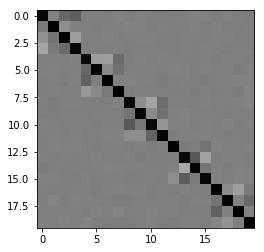

In [16]:
A, X, super_gauss = gen_super_gauss(dim=20, red_dim=20, T=10000, sub_dim=4, seed=5)
W_true = np.linalg.inv(A)
W, S, R = fastISA(X=X, dim=20, red_dim=20, T=10000, sub_dim=4, maxiter=15, seed=5, A_init=A)
plt.figure()
plt.imshow(np.dot(np.dot(W, R), A), cmap='gray', vmin=-1, vmax=1)
print("amari_index ", amari_index(np.dot(np.dot(W, R), A), 4))